# Review of PK results for Erlotinib and Gefitinib from [[1]]

Reproduces the PKn modelling results from [[1](ref)] by incrementally reproducing

1. the structural model,
2. the error model,
3. the population model.

The parameters for the forward simulation are taken from [[1](ref)].

<a name="ref"> [1] </a> Eigenmann et. al., Combining Nonclinical Experiments with Translational PKPD Modeling to Differentiate Erlotinib and Gefitinib, Mol Cancer Ther (2016)

## 1. Structural model

The structural model according to [[1](ref)] consists of a one-compartmental PK model

\begin{align}
\frac{\text{d}A}{\text{d}t} &= - k_e A + \text{Dose}\\
C &= \frac{A}{V}.
\end{align}

Here 
- $A$ is the drug amount in the blood plasma in $[$mg$]$,
- $C$ the drug concentration in the blood plasma in $[$mg/L$]$, and
- $k_e$ the drug elimination rate in $[$1/day$]$.

The Dose variable is representative for direct or indirect dose administration, i.e. bolus injection into the blood plasma or injection into a secondary dose compartment which is linearly connected to the blood plasma. In either case we will refer to the blood plasma as dose compartment. If the drug is administered indirectly we will refer to the secondary compartment as depot compartment.

The study investigated oral dosing strategies which can be modelled by an indirect drug administration
\begin{align}
\frac{\text{d}A_{d}}{\text{d}t} &= r_{\text{dose}} - k_a A_{d}\\
\text{Dose} &= k_a A_{d},
\end{align}

where
- $A_d$ is the drug amount in the depot compartment in $[$mg$]$,
- $r_{\text{dose}}$ the dose rate at which the dose is applied to the depot compartment in $[$mg/day$]$ and
- $k_a$ the absorption rate from the depot compartment to the blood plasma in $[$1/day$]$. 

### 1.1 Build Structural Model

The structural model is constructed with myokit. For details please check the pkpd.model module.

In [1]:
import myokit

from pkpd import model as m

# Build tumor growth inhibition model with default parameters
model = m.create_one_comp_pk_model()

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Print model
print(model.code())

[[model]]
# Initial values
central.amount = 0

[central]
dot(amount) = -k_e * amount
    in [mg]
conc = amount / volume
    in [mg/L]
k_e = 0
    in [1/day]
time = 0 bind time
    in [day]
volume = 1
    in [L]




### 1.2 Set oral administration

In [2]:
# set route of administration
model.set_roa(dose_comp='central', indirect=True)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Print model
print(model.code())

[[model]]
# Initial values
central.amount = 0
depot.amount   = 0

[central]
dot(amount) = -k_e * amount + depot.k_a * depot.amount
    in [mg]
conc = amount / volume
    in [mg/L]
k_e = 0
    in [1/day]
time = 0 bind time
    in [day]
volume = 1
    in [L]

[depot]
dot(amount) = -k_a * amount + dose_rate * regimen
dose_rate = 0
k_a = 0
regimen = 0 bind pace




### 1.3 Illustrate predicted mean plasma concentration for A677 patient-derived tumour explants

The intitial conditions and parameters are set according to the inferred values for A667 in Table 1 in [[1](ref)]. 

### 1.3.1 Treated tumour growth

We can model the distribution of Erlotinib in mice when treated with a daily oral dose of 25 mg/kg/day from day 2-15. For simplicity we just assume that the subject weighs 0.02kg.

#### 1.3.2.1 Set dosing regimen

In [14]:
# define regimen
amount = 25 * 0.02  # mg (25 mg per kg)
duration = 0.001 # How long does it take to apply oral dose
start = 0 # start on the first day
period = 1 # dose every day
multiplier = 14 # apply the dose 14 times

model.set_regimen(
    amount=amount,
    duration=duration, 
    start=start, 
    period=period,
    multiplier=multiplier)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Print model
print(model.code())

[[model]]
# Initial values
central.amount = 0
depot.amount   = 0

[central]
dot(amount) = -k_e * amount + depot.k_a * depot.amount
    in [mg]
conc = amount / volume
    in [mg/L]
k_e = 3.87
    in [1/day]
time = 0 bind time
    in [day]
volume = 1.4
    in [L]

[depot]
dot(amount) = -k_a * amount + dose_rate * regimen
    in [mg]
dose_rate = 500
k_a = 55
    in [1/day]
regimen = 0 bind pace




#### 1.3.2.2 Set PK parameters for Erlotinib and simulate

In [15]:
# Set PK parameters 
# Define state and parameter names
names = [
    'central.amount',
    'depot.amount',
    'central.k_e',
    'central.volume',
    'depot.k_a',
]

# Define intial conditions and values according to reference.
values = [
    0,  # central.amount
    0,  # depot.amount
    7.56,  # k_e
    0.127,  # volume
    55,  # k_a
] 

# Define units of values
units = [
    'mg',  # central.amount
    'mg',  # depot.amount
    '1/day',  # k_e
    'L',  # volume
    '1/day',  # k_a
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Run simulation for one day
_, regimen = model.dosing_regimen()
simulation = myokit.Simulation(model, regimen)
result = simulation.run(1)

# Get tumour volume - time curve
time_key = 'central.time'
conc_key = 'central.conc'

time_erlo = result[time_key]
conc_erlo = result[conc_key]

#### 1.3.2.3 Set PK parameters for Gefitinib and simulate

Note that in [[1](ref)] the volume of distribution $V$ was assumed to be dose dependent. We assume dose independent $V$.

In [16]:
# Set PK parameters 
# Define state and parameter names
names = [
    'central.amount',
    'depot.amount',
    'central.k_e',
    'central.volume',
    'depot.k_a',
]

# Define intial conditions and values according to reference.
values = [
    0,  # central.amount
    0,  # depot.amount
    3.87,  # k_e
    1.4,  # volume
    55,  # k_a
] 

# Define units of values
units = [
    'mg',  # central.amount
    'mg',  # depot.amount
    '1/day',  # k_e
    'L',  # volume
    '1/day',  # k_a
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Run simulation for one day
_, regimen = model.dosing_regimen()
simulation = myokit.Simulation(model, regimen)
result = simulation.run(1)

# Get tumour volume - time curve
time_key = 'central.time'
conc_key = 'central.conc'

time_gefi = result[time_key]
conc_gefi = result[conc_key]

#### 1.3.2.4 Illustrate treated tumour growth

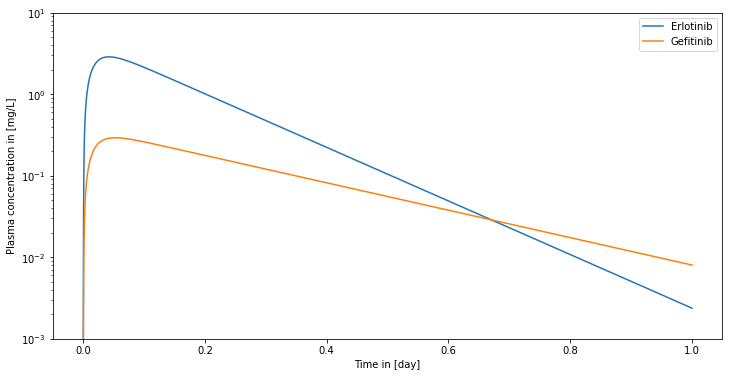

In [17]:
import matplotlib.pyplot as plt

# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# Semi log plot
plt.semilogy(time_erlo, conc_erlo, label='Erlotinib')
plt.semilogy(time_gefi, conc_gefi, label='Gefitinib')

# Set x and y axis label
plt.xlabel('Time in [day]')
plt.ylabel('Plasma concentration in [mg/L]')

# Set y limits
plt.ylim([1E-3, 1E1])

# Create legend
plt.legend()

plt.show()

## 2. Error Model

In [[1](ref)] the discrepancy between the structural model and the observations through measurement noise and modelling assumptions was modelled by a combined error model

\begin{align}
V^{\text{obs}}_T-V_T \sim (a + b V_T) \varepsilon ,
\end{align}
where 
- $V^{\text{obs}}_T$ is the observed tumour volume at the measured time points in $[$mm$^3]$, 
- $V_T$ the predicted tumour volume at the different time points in $[$mm$^3]$, 
- $a$ a real constant in $[$mm$^3]$,
- $b$ a dimensionless real constant, and 
- $\varepsilon $ a dimensionless, standard normal distributed random variable, i.e. $\varepsilon \sim \mathcal{N}(0, 1)$.

In other words, the measured volume of the tumour at different time points can be predicted with 

\begin{align}
V^{\text{pred}}_T= V_T + \text{Noise} ,
\end{align}

based on the deterministic predictions from the structural model $V_T$ and the expected deviations from measurement noise and modelling assumptions $\text{Noise}\sim (a + b V_T) \varepsilon$.

### 2.1 Illustrate error model

We can visualise the error model by showing how the error is expected to grow with the values of $V_T$, and by showing how the measurements are expected to scatter around the predictions of the structural model.

For illustration purposes, uncertainty in $a$ and $b$ is neglected for the moment and the mean values of $a$ and $b$ are taken from [[1](ref)].

#### 2.1.1 Structural model + noise versus structural model

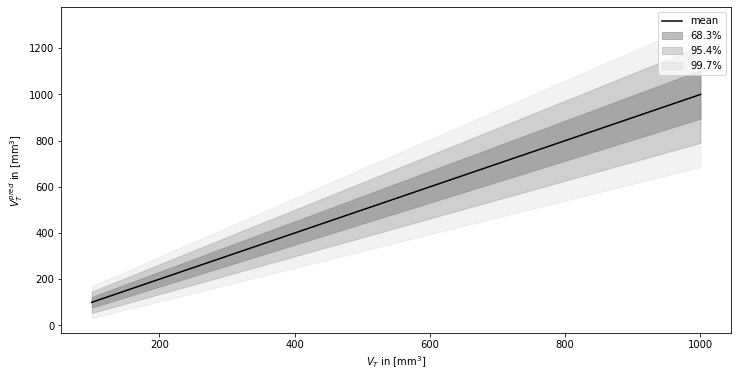

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# a and b values from reference
a = 14.1  # in mm^3
b = 0.0907  # dimensionless

# Define span of relevant V_T values
volume_t = np.linspace(100, 1000)

# Predicted volume plus mean noise (=0)
volume_plus_mean_noise = volume_t + 0

# Predicted volume plus 1-sigma noise
one_sigma_noise = (a + b * volume_t) * 1

# Predicted volume plus 2-sigma noise
two_sigma_noise = (a + b * volume_t) * 2

# Predicted volume plus 3-sigma noise
three_sigma_noise = (a + b * volume_t) * 3

# Create loglog plot
fig = plt.figure(figsize=(12, 6))

# Structural model versus mean prediction
plt.plot(volume_t, volume_plus_mean_noise, linestyle='solid', color='black', label='mean')

# Shade 1-sigma interval (68.3%)
plt.fill_between(
    x=volume_t, 
    y1=volume_t + one_sigma_noise,
    y2=volume_t - one_sigma_noise,
    color='gray',
    alpha=0.5,
    label='68.3%')

# Shade 2-sigma interval (95.4%)
plt.fill_between(
    x=volume_t, 
    y1=volume_t + two_sigma_noise,
    y2=volume_t - two_sigma_noise,
    color='gray',
    alpha=0.3,
    label='95.4%')

# Shade 3-sigma interval (99.7%)
plt.fill_between(
    x=volume_t, 
    y1=volume_t + three_sigma_noise,
    y2=volume_t - three_sigma_noise,
    color='gray',
    alpha=0.1,
    label='99.7%')

# Create x and y label
plt.xlabel(r'$V_T$ in [mm$^3$]')
plt.ylabel(r'$V^{pred}_T$ in [mm$^3$]')

# Create legend
plt.legend()

plt.show()

#### 2.1.2 Illustrate uncertainty in untreated tumour growth from measurement error and structural model assumptions

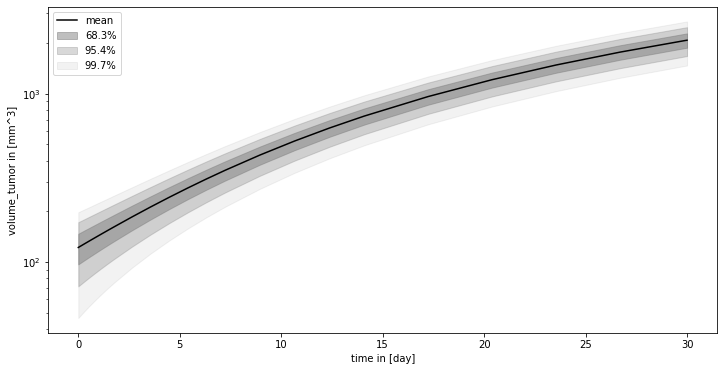

In [10]:
# Same as 1.3.1.1
# Define state and parameter names
names = [
    'central.time',
    'central.volume_tumor',
    'central.kappa',
    'central.lambda_0',
    'central.lambda_1',
]

# Define intial conditions and values according to reference.
values = [
    0,  # time
    122,  # volume_tumor
    0,  # kappa (growth in absence of drug)
    0.0971,  # lambda_0
    127,  # lambda_1
] 

# Define units of values
units = [
    'day',  # time
    'mm^3',  # volume_tumor
    'L/mg/day',  # kappa
    '1/day',  # lambda_0
    'mm^3/day',  # lambda_1
]

# set variables
model.set_values(names, values, units)

# Same as 1.3.2.3
# Run simulation for 30 days
simulation = myokit.Simulation(model)
result = simulation.run(30)

# Get tumour volume - time curve
time_key = 'central.time'
tumor_key = 'central.volume_tumor'

time = np.array(result[time_key])
volume = np.array(result[tumor_key])

# Compute noise intervals
a = 14.1  # in mm^3
b = 0.0907  # dimensionless
one_sigma_noise = (a + b * volume) * 1
two_sigma_noise = (a + b * volume) * 2
three_sigma_noise = (a + b * volume) * 3

# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# semi log plot
plt.semilogy(time, volume, linestyle='solid', color='black', label='mean')

# Shade 1-sigma interval (68.3%)
plt.fill_between(
    x=time, 
    y1=volume + one_sigma_noise,
    y2=volume - one_sigma_noise,
    color='gray',
    alpha=0.5,
    label='68.3%')

# Shade 2-sigma interval (95.4%)
plt.fill_between(
    x=time, 
    y1=volume + two_sigma_noise,
    y2=volume - two_sigma_noise,
    color='gray',
    alpha=0.3,
    label='95.4%')

# Shade 3-sigma interval (99.7%)
plt.fill_between(
    x=time, 
    y1=volume + three_sigma_noise,
    y2=volume - three_sigma_noise,
    color='gray',
    alpha=0.1,
    label='99.7%')

# set x and y axis label
plt.xlabel('%s in %s' % (time_key.split('.')[1], model.var(time_key).unit()))
plt.ylabel('%s in %s' % (tumor_key.split('.')[1], model.var(tumor_key).unit()))

# Create legend
plt.legend()

plt.show()

#### 2.1.2 Illustrate uncertainty in Erlotinib treated tumour growth from measurement error and structural model assumptions

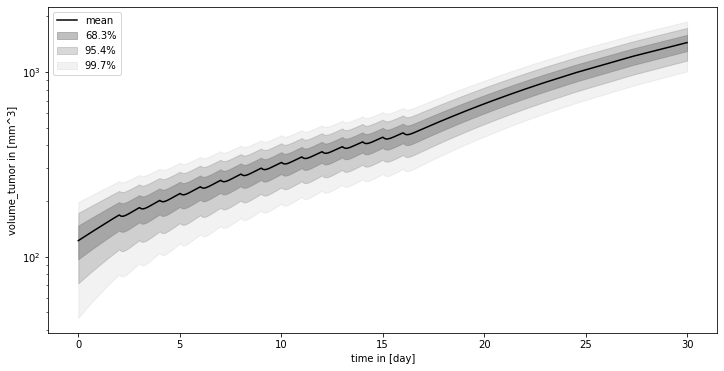

In [11]:
# Same as 1.3.2.1
# Define regimen
amount = 25 * 0.02  # mg (25 mg per kg)
duration = 0.001 # How long does it take to apply oral dose
start = 2 # start on the first day
period = 1 # dose every day
multiplier = 14 # apply the dose 14 times

model.set_regimen(
    amount=amount,
    duration=duration, 
    start=start, 
    period=period,
    multiplier=multiplier)

# Same as 1.3.2.2
# Set PK parameters 
# Define state and parameter names
names = [
    'central.amount',
    'depot.amount',
    'central.k_e',
    'central.kappa',
    'central.volume',
    'depot.k_a',
]

# Define intial conditions and values according to reference.
values = [
    0,  # central.amount
    0,  # depot.amount
    7.56,  # k_e
    0.117,  # kappa (growth in absence of drug)
    0.127,  # volume
    55,  # k_a
] 

# Define units of values
units = [
    'mg',  # central.amount
    'mg',  # depot.amount
    '1/day',  # k_e
    'L/mg/day',  # kappa
    'L',  # volume
    '1/day',  # k_a
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Run simulation for 30 days
_, regimen = model.dosing_regimen()
simulation = myokit.Simulation(model, regimen)
result = simulation.run(30)

# Get tumour volume - time curve
time_key = 'central.time'
tumor_key = 'central.volume_tumor'

time = np.array(result[time_key])
volume = np.array(result[tumor_key])

# Compute noise intervals
a = 14.1  # in mm^3
b = 0.0907  # dimensionless
one_sigma_noise = (a + b * volume) * 1
two_sigma_noise = (a + b * volume) * 2
three_sigma_noise = (a + b * volume) * 3

# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# semi log plot
plt.semilogy(time, volume, linestyle='solid', color='black', label='mean')

# Shade 1-sigma interval (68.3%)
plt.fill_between(
    x=time, 
    y1=volume + one_sigma_noise,
    y2=volume - one_sigma_noise,
    color='gray',
    alpha=0.5,
    label='68.3%')

# Shade 2-sigma interval (95.4%)
plt.fill_between(
    x=time, 
    y1=volume + two_sigma_noise,
    y2=volume - two_sigma_noise,
    color='gray',
    alpha=0.3,
    label='95.4%')

# Shade 3-sigma interval (99.7%)
plt.fill_between(
    x=time, 
    y1=volume + three_sigma_noise,
    y2=volume - three_sigma_noise,
    color='gray',
    alpha=0.1,
    label='99.7%')

# set x and y axis label
plt.xlabel('%s in %s' % (time_key.split('.')[1], model.var(time_key).unit()))
plt.ylabel('%s in %s' % (tumor_key.split('.')[1], model.var(tumor_key).unit()))

# Create legend
plt.legend()

plt.show()

#### 2.1.3 Illustrate uncertainty in Gefitinib treated tumour growth from measurement error and structural model assumptions

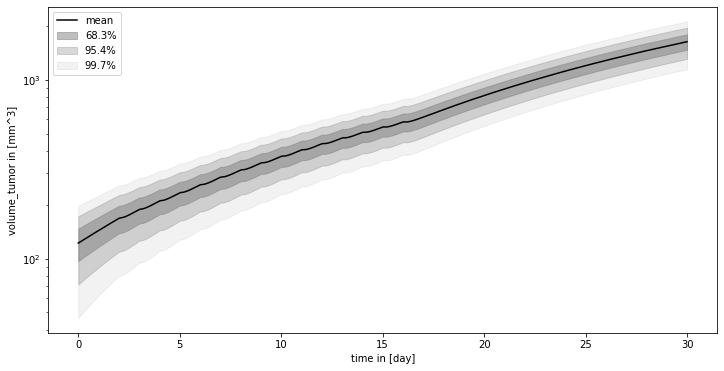

In [12]:
# Same as 1.3.2.1
# Define regimen
amount = 25 * 0.02  # mg (25 mg per kg)
duration = 0.001 # How long does it take to apply oral dose
start = 2 # start on the first day
period = 1 # dose every day
multiplier = 15 # apply the dose 14 times

model.set_regimen(
    amount=amount,
    duration=duration, 
    start=start, 
    period=period,
    multiplier=multiplier)

# Same as 1.3.2.3
# Set PK parameters 
# Define state and parameter names
names = [
    'central.amount',
    'depot.amount',
    'central.k_e',
    'central.kappa',
    'central.volume',
    'depot.k_a',
]

# Define intial conditions and values according to reference.
values = [
    0,  # central.amount
    0,  # depot.amount
    3.87,  # k_e
    0.43,  # kappa (growth in absence of drug)
    1.4,  # volume
    55,  # k_a
] 

# Define units of values
units = [
    'mg',  # central.amount
    'mg',  # depot.amount
    '1/day',  # k_e
    'L/mg/day',  # kappa
    'L',  # volume
    '1/day',  # k_a
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Run simulation for 30 days
_, regimen = model.dosing_regimen()
simulation = myokit.Simulation(model, regimen)
result = simulation.run(30)

# Get tumour volume - time curve
time_key = 'central.time'
tumor_key = 'central.volume_tumor'

time = np.array(result[time_key])
volume = np.array(result[tumor_key])

# Compute noise intervals
a = 14.1  # in mm^3
b = 0.0907  # dimensionless
one_sigma_noise = (a + b * volume) * 1
two_sigma_noise = (a + b * volume) * 2
three_sigma_noise = (a + b * volume) * 3

# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# semi log plot
plt.semilogy(time, volume, linestyle='solid', color='black', label='mean')

# Shade 1-sigma interval (68.3%)
plt.fill_between(
    x=time, 
    y1=volume + one_sigma_noise,
    y2=volume - one_sigma_noise,
    color='gray',
    alpha=0.5,
    label='68.3%')

# Shade 2-sigma interval (95.4%)
plt.fill_between(
    x=time, 
    y1=volume + two_sigma_noise,
    y2=volume - two_sigma_noise,
    color='gray',
    alpha=0.3,
    label='95.4%')

# Shade 3-sigma interval (99.7%)
plt.fill_between(
    x=time, 
    y1=volume + three_sigma_noise,
    y2=volume - three_sigma_noise,
    color='gray',
    alpha=0.1,
    label='99.7%')

# set x and y axis label
plt.xlabel('%s in %s' % (time_key.split('.')[1], model.var(time_key).unit()))
plt.ylabel('%s in %s' % (tumor_key.split('.')[1], model.var(tumor_key).unit()))

# Create legend
plt.legend()

plt.show()

## 3. Population model

So far we have simulated the tumour growth for a fixed set of PK and PD parameters for Erlotinib and Gefitinib. This equivalent to assuming that Erlotinib and Gefinitib will affect all patients exactly the same, and that the only deviations of the observations from the predictions is due to measurement noise or some flaws of the structural model. However, it is well established that individuals react vastly differently to drugs.

In [[1](ref)] the inter-individual variation is addressed by assuming that the structural model parameters $V$, $k_e$, $\lambda_0$, $\lambda_1$, $\kappa $ and the inital tumour volume $V_{T,0}$ vary across individuals in a population (The absorption coefficient $k_a$ appears to have been fixed across indiviudals withoour further justification). In particular, all parameters $\psi = (V, k_e, \lambda_0, \lambda_1, \kappa, V_{T,0})$ were assumed to be normally distributed in the population 
\begin{align}
\psi _i \sim \mathcal{N}(\bar{\psi }_i, \sigma _i).
\end{align}

As a result, the response of an individual patient can be simulated by drawing one realisation of $\psi $ from the distribution, solve the structural model and add uncertainty according to the error model. In fact, so far we have set $\psi = \bar{\psi }$ and simulated therefore a virtual *mean* patient of the population.

### 3.1 Illustrate uncertainty in tumour growth through inter-individual variability (assuming no measurement noise and an exact structural model)

Because the dependence of the tumour growth on the strutural parameters $\psi $ there is no straightforward analytical way to find the uncertainty intervals as before with the error model. So we will find the uncertainty approximately, by simulating the tumour growth for many virtual patients, and estimate the error bounds.

#### 3.1.1 Untreated tumour growth

#### 3.1.1.1 Set fixed intial conditions and parameters

In [13]:
# Define state and parameter names
names = [
    'central.time',
    'central.kappa'
]

# Define intial conditions and values according to reference.
values = [
    0,  # time
    0  # kappa (growth in absence of drug)
] 

# Define units of values
units = [
    'day',  # time
    'L/mg/day'  # kappa
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

#### 3.1.1.2 Simulate $N$ individuals

In [29]:
# Define population size
N = 1000

# Define mean and variance of structural model parameters
psi_mean = np.array([
    0.0971,  # lambda_0 in [1/day]
    127,  # lambda_1 in [mm^3/day]
    122,  # inital tumour volume in [mm^3]
])
#TODO: not clear whether variation is given relative or not
psi_var = np.array([
    [0.0456, 0, 0],  # lambda_0 in [1/day]  TODO: reduced std by factor 0.1 to what is given in table. Typo?
    [0, 0.710, 0], # lambda_1 in [mm^3/day]
    [0, 0, 0.368]  # inital tumour volume in [mm^3]
]) ** 2

# Define logging time
time = np.linspace(0, 30)

# Insantiate simulation
sim = myokit.Simulation(model)

# Instantiate result container
result = np.empty(shape=(N, len(time)))

# Solve structural model for individuals
for idn, n in enumerate(range(N)):
    # Reset simulation
    sim.reset()

    # draw individual from distribution
    psi = np.random.multivariate_normal(
        mean=psi_mean,
        cov=psi_var
    )

    # make sure parameters are positive
    psi = np.clip(psi, 0, None)

    # Set parameter values
    # Define state and parameter names
    names = [
        'central.lambda_0',
        'central.lambda_1'
    ]

    # Set parameters
    for idname, name in enumerate(names):
        sim.set_constant(name, psi[idname])

    # Set inital conditions
    sim.set_default_state([0.0, psi[2], 0.0])

    # Simulate
    result[idn, :] = np.array(sim.run(31, log=['central.volume_tumor'], log_times=time)['central.volume_tumor'])

#### 3.1.1.3 Illustrate variation of untreated tumour growth through interindividual variability

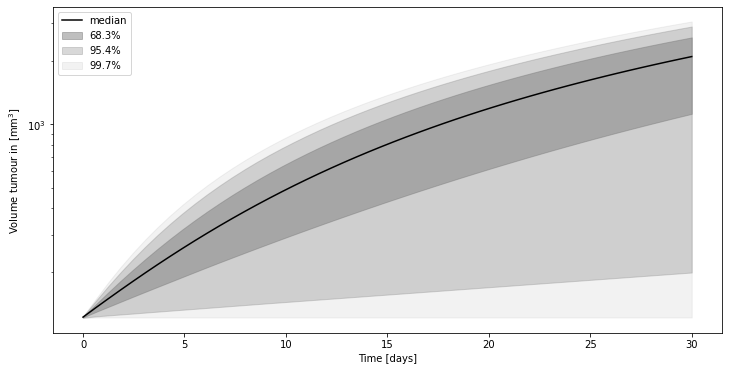

In [30]:
# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# Compute median growth
median = np.median(result, axis=0)

# semi log plot
plt.semilogy(time, median, linestyle='solid', color='black', label='median')

# Shade 1-sigma interval (68.3%),
# i.e. 0.159 to 0.841 precentile
p_left = 15.9
p_right = 84.1
plt.fill_between(
    x=time, 
    y1=np.percentile(result, p_left, axis=0),
    y2=np.percentile(result, p_right, axis=0),
    color='gray',
    alpha=0.5,
    label='68.3%')

# # Shade 2-sigma interval (95.4%)
# i.e. 0. 023 to 0.977 precentile
p_left = 2.3
p_right = 97.7
plt.fill_between(
    x=time, 
    y1=np.percentile(result, p_left, axis=0),
    y2=np.percentile(result, p_right, axis=0),
    color='gray',
    alpha=0.3,
    label='95.4%')

# # Shade 3-sigma interval (99.7%)
# i.e. 0. 013 to 0.987 precentile
p_left = 0.1
p_right = 99.9
plt.fill_between(
    x=time, 
    y1=np.percentile(result, p_left, axis=0),
    y2=np.percentile(result, p_right, axis=0),
    color='gray',
    alpha=0.1,
    label='99.7%')

# set x and y axis label
plt.xlabel('Time [days]')
plt.ylabel(r'Volume tumour in [mm$^3$]')

# Create legend
plt.legend()

plt.show()

### 3.1.2 Erlotinib treated tumour growth

#### 3.1.2.1 Set fixed initial values and parameters

In [31]:
# Same as 1.3.2.2
# Set PK parameters 
# Define state and parameter names
names = [
    'central.amount',
    'depot.amount',
    'depot.k_a',
]

# Define intial conditions and values according to reference.
values = [
    0,  # central.amount
    0,  # depot.amount
    55,  # k_a
] 

# Define units of values
units = [
    'mg',  # central.amount
    'mg',  # depot.amount
    '1/day',  # k_a
]

# set variables
model.set_values(names, values, units)

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

#### 3.1.3.2 Medium dose 

In [ ]:
# Same as 1.3.2.1
# Define regimen
amount = 25 * 0.02  # mg (25 mg per kg)
duration = 0.001 # How long does it take to apply oral dose
start = 2 # start on the first day
period = 1 # dose every day
multiplier = 14 # apply the dose 14 times

model.set_regimen(
    amount=amount,
    duration=duration, 
    start=start, 
    period=period,
    multiplier=multiplier)

# Define population size
N = 1000

# Define mean and variance of structural model parameters
psi_mean = np.array([
    0.127,  # volume in [L]
    7.56,  # k_e in [1/day]
    0.117
    0.0971,  # lambda_0 in [1/day]
    127,  # lambda_1 in [mm^3/day]
    122,  # inital tumour volume in [mm^3]
])
#TODO: not clear whether variation is given relative or not
psi_var = np.array([
    [0.0456, 0, 0],  # lambda_0 in [1/day]  TODO: reduced std by factor 0.1 to what is given in table. Typo?
    [0, 0.710, 0], # lambda_1 in [mm^3/day]
    [0, 0, 0.368]  # inital tumour volume in [mm^3]
]) ** 2

# Define logging time
time = np.linspace(0, 30)

# Insantiate simulation
sim = myokit.Simulation(model)

# Instantiate result container
result = np.empty(shape=(N, len(time)))

# Solve structural model for individuals
for idn, n in enumerate(range(N)):
    # Reset simulation
    sim.reset()

    # draw individual from distribution
    psi = np.random.multivariate_normal(
        mean=psi_mean,
        cov=psi_var
    )

    # make sure parameters are positive
    psi = np.clip(psi, 0, None)

    # Set parameter values
    # Define state and parameter names
    names = [
        'central.lambda_0',
        'central.lambda_1'
    ]

    # Set parameters
    for idname, name in enumerate(names):
        sim.set_constant(name, psi[idname])

    # Set inital conditions
    sim.set_default_state([0.0, psi[2], 0.0])

    # Simulate
    result[idn, :] = np.array(sim.run(31, log=['central.volume_tumor'], log_times=time)['central.volume_tumor'])


# Run simulation for 30 days
_, regimen = model.dosing_regimen()
simulation = myokit.Simulation(model, regimen)
result = simulation.run(30)

# Get tumour volume - time curve
time_key = 'central.time'
tumor_key = 'central.volume_tumor'

time = np.array(result[time_key])
volume = np.array(result[tumor_key])

# Compute noise intervals
a = 14.1  # in mm^3
b = 0.0907  # dimensionless
one_sigma_noise = (a + b * volume) * 1
two_sigma_noise = (a + b * volume) * 2
three_sigma_noise = (a + b * volume) * 3

# Illustrate time series
fig = plt.figure(figsize=(12, 6))

# semi log plot
plt.semilogy(time, volume, linestyle='solid', color='black', label='mean')

# Shade 1-sigma interval (68.3%)
plt.fill_between(
    x=time, 
    y1=volume + one_sigma_noise,
    y2=volume - one_sigma_noise,
    color='gray',
    alpha=0.5,
    label='68.3%')

# Shade 2-sigma interval (95.4%)
plt.fill_between(
    x=time, 
    y1=volume + two_sigma_noise,
    y2=volume - two_sigma_noise,
    color='gray',
    alpha=0.3,
    label='95.4%')

# Shade 3-sigma interval (99.7%)
plt.fill_between(
    x=time, 
    y1=volume + three_sigma_noise,
    y2=volume - three_sigma_noise,
    color='gray',
    alpha=0.1,
    label='99.7%')

# set x and y axis label
plt.xlabel('%s in %s' % (time_key.split('.')[1], model.var(time_key).unit()))
plt.ylabel('%s in %s' % (tumor_key.split('.')[1], model.var(tumor_key).unit()))

# Create legend
plt.legend()

plt.show()

### 3.1.2 Gefitinib treated tumour growth

## 3.2 Final predictions

The final predictions for tumour growth in the population are now a composite of the strutural model, the distribution of structural model parameters in the population and the expected deviations of the observations from the model through measurement error and modelling assumptions. So assuming that we had infinite data and the population level parameters $\bar{\psi} $, $\sigma $ and $a$ and $b$ could be determined with hundert percent precision, this is the best we can do with modelling the population response to Erlotinib and Gefitinib. However, in [[1](ref)] the parameters were inferred from finite data sets, and therefore carry uncertainty as well. As a result, the model predictions carry uncertainty from from inter-individual variability, deviations from observatios and predictions, and uncertainty in the model parameters.